# Classifier problem 
J. Cristiano

In this notebook, I'll solve the issue of sorting good images from bad images.  

The current solution is to use logistic regression on the embedding space of the segmentation models
#### Step 1: Dataset Creation

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import v2
from PIL import Image, ImageDraw
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
from typing import Any, Dict, List, Literal, Union, Type

import torchvision.transforms.v2.functional as F
from torchvision.transforms import v2
from torchvision.transforms.v2._utils import (
    _check_padding_mode_arg,
    _get_fill,
    _setup_fill_arg,
    _FillType,
)


class PadSquare(v2.Transform):
    """Pad a non-square input to make it square by padding the shorter side to match the longer side.
    Args:
        fill (number or tuple or dict, optional): Pixel fill value used when the  ``padding_mode`` is constant.
            Default is 0. If a tuple of length 3, it is used to fill R, G, B channels respectively.
            Fill value can be also a dictionary mapping data type to the fill value, e.g.
            ``fill={tv_tensors.Image: 127, tv_tensors.Mask: 0}`` where ``Image`` will be filled with 127 and
            ``Mask`` will be filled with 0.
        padding_mode (str, optional): Type of padding. Should be: constant, edge, reflect or symmetric.
            Default is "constant".

            - constant: pads with a constant value, this value is specified with fill

            - edge: pads with the last value at the edge of the image.

            - reflect: pads with reflection of image without repeating the last value on the edge.
              For example, padding [1, 2, 3, 4] with 2 elements on both sides in reflect mode
              will result in [3, 2, 1, 2, 3, 4, 3, 2]

            - symmetric: pads with reflection of image repeating the last value on the edge.
              For example, padding [1, 2, 3, 4] with 2 elements on both sides in symmetric mode
              will result in [2, 1, 1, 2, 3, 4, 4, 3]

    Example:
        >>> import torch
        >>> from torchvision.transforms.v2 import PadSquare
        >>> rectangular_image = torch.randint(0, 255, (3, 224, 168), dtype=torch.uint8)
        >>> transform = PadSquare(padding_mode='constant', fill=0)
        >>> square_image = transform(rectangular_image)
        >>> print(square_image.size())
        torch.Size([3, 224, 224])
    """

    def __init__(
        self,
        fill: Union[_FillType, Dict[Union[Type, str], _FillType]] = 0,
        padding_mode: Literal["constant", "edge", "reflect", "symmetric"] = "constant",
    ):
        super().__init__()

        _check_padding_mode_arg(padding_mode)

        if padding_mode not in ["constant", "edge", "reflect", "symmetric"]:
            raise ValueError(
                "`padding_mode` must be one of 'constant', 'edge', 'reflect' or 'symmetric'."
            )
        self.padding_mode = padding_mode
        self.fill = _setup_fill_arg(fill)

    def _get_params(self, flat_inputs: List[Any]) -> Dict[str, Any]:
        # Get the original height and width from the inputs
        orig_height, orig_width = v2.query_size(flat_inputs)

        # Find the target size (maximum of height and width)
        target_size = max(orig_height, orig_width)

        if orig_height < target_size:
            # Need to pad height
            pad_height = target_size - orig_height
            pad_top = pad_height // 2
            pad_bottom = pad_height - pad_top
            pad_left = 0
            pad_right = 0
        else:
            # Need to pad width
            pad_width = target_size - orig_width
            pad_left = pad_width // 2
            pad_right = pad_width - pad_left
            pad_top = 0
            pad_bottom = 0

        # The padding needs to be in the format [left, top, right, bottom]
        return dict(padding=[pad_left, pad_top, pad_right, pad_bottom])

    def _transform(self, inpt: Any, params: Dict[str, Any]) -> Any:
        fill = _get_fill(self.fill, type(inpt))
        return self._call_kernel(
            F.pad,
            inpt,
            padding=params["padding"],
            padding_mode=self.padding_mode,
            fill=fill
        )

In [3]:
coco_root = '/work/2023_annot/images'
coco_annFile = '/work/2023_annot/2023_annotations.json'
standard_transform = transforms.v2.Compose([
    PadSquare(0), 
    v2.Resize((512, 512)), 
    v2.ToImage()
    ])
# First wrap the dataset with the new taggable key
full_dataset = datasets.CocoDetection(root=coco_root, annFile=coco_annFile, transforms=standard_transform)
full_dataset = datasets.wrap_dataset_for_transforms_v2(full_dataset, target_keys=("labels", "masks"))
bad_samples_root = '/work/2023_annot/bad_samples/'
classifier_dataset = datasets.ImageFolder(root=bad_samples_root, transform=standard_transform)
# Add labels to the classifier_dataset
classifier_dataset = [(img, 0) for img, _ in classifier_dataset]
#sort the taggable images from the annotation dataset
for i in tqdm(range(len(full_dataset))):
    labels = full_dataset[i][1]["labels"]
    taggable = (len(torch.unique(labels)) == 3)
    if taggable:
        classifier_dataset.append((full_dataset[i][0], 1))
    else:
        classifier_dataset.append((full_dataset[i][0], 0))
train_size = int(0.8 * len(classifier_dataset))
test_size = int(0.2 * len(classifier_dataset))
test_size += len(classifier_dataset) - (train_size + test_size)
print(f"Train size: {train_size}, Test size: {test_size}")
classifier_dataset_train, classifier_dataset_test = torch.utils.data.random_split(classifier_dataset, [train_size, test_size])
# Now we can use the classifier_dataset for training
del full_dataset

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


100%|█████████████████████████████████████████| 102/102 [00:23<00:00,  4.33it/s]

Train size: 145, Test size: 37


Next, I will obtain a mix of 74 bad photos and put them in a sub folder, creating a new classifier dataset. 


In [4]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import torch.nn as nn
preprocess_input = get_preprocessing_fn('resnet34', pretrained='imagenet')
model = smp.Unet('resnet34', encoder_weights='imagenet', in_channels=3, classes=4, activation=None)
model.load_state_dict(torch.load('/work/multiclass_multiyear_UNET_sm.pth', map_location=device,weights_only=True))
model = model.to(device)

In [5]:
# TODO: bring in the CLIP example to show improvements over it
import os
# import clip
from sklearn.linear_model import LogisticRegression
from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.model_selection import GridSearchCV
def get_UNET_features(dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=1)):
            img = torch.stack([torch.tensor(preprocess_input(i.permute(1, 2, 0).numpy())) for i in images])
            img = img.permute(0, 3, 1, 2).float()
            result = model.encoder(img.to(device))
            features = result[-1]
            # Get the batch size and space size dynamically
            batch_size, space_size, _, _ = features.shape
            flattened_tensor = features.view(batch_size, space_size, -1).mean(dim=-1)
            all_features.append(flattened_tensor.cpu())
            all_labels.append(labels)

    return torch.cat(all_features).numpy(), torch.cat(all_labels).numpy()

train_x, train_y = get_UNET_features(classifier_dataset_train)
test_x, test_y = get_UNET_features(classifier_dataset_test)

# Define the parameter grid
param_grid = {'C': np.logspace(-4, 4, 20)}

# Initialize the logistic regression model
logistic = LogisticRegression(random_state=0, max_iter=10000)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(logistic, param_grid, cv=5, verbose=1, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(train_x, train_y)

# Get the best parameter and the best score
best_C = grid_search.best_params_['C']
best_score = grid_search.best_score_

print(f"Best C: {best_C}")
print(f"Best cross-validation accuracy: {best_score:.3f}")

# Evaluate using the best logistic regression classifier
best_classifier = grid_search.best_estimator_
predictions = best_classifier.predict(test_x)
accuracy = np.mean((test_y == predictions).astype(float)) * 100.
print(f"Test accuracy = {accuracy:.3f}")

# Save the best classifier
torch.save(best_classifier, '/work/best_classifier.pth')


100%|███████████████████████████████████████████| 37/37 [00:32<00:00,  1.13it/s]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Best C: 11.288378916846883
Best cross-validation accuracy: 0.883
Test accuracy = 89.189


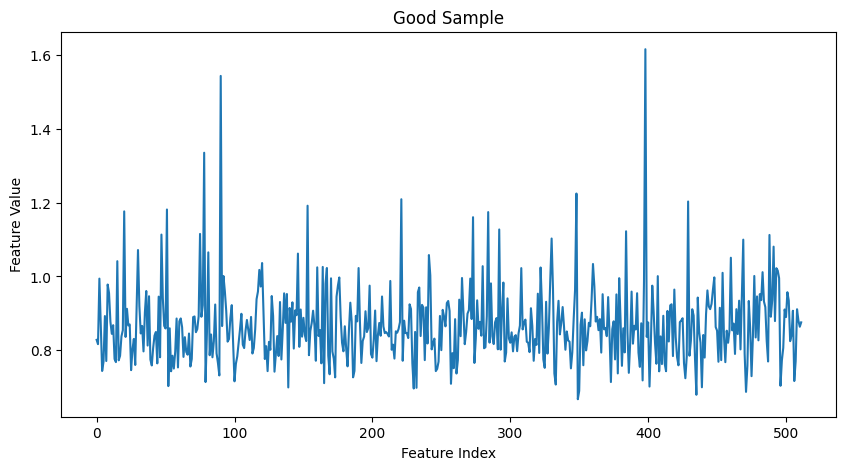

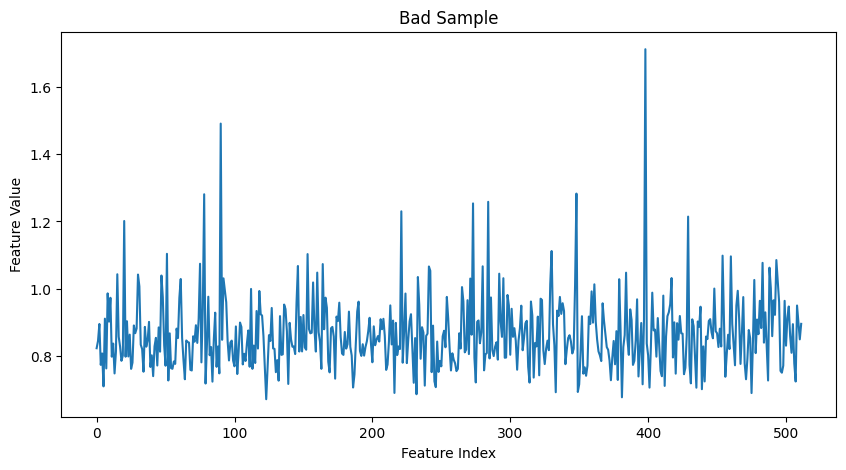

In [6]:
# print(train_x[1], train_y[2]) 

plt.figure(figsize=(10, 5))
plt.plot(train_x[0])
plt.title('Good Sample')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_x[2])
plt.title('Bad Sample')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.show()

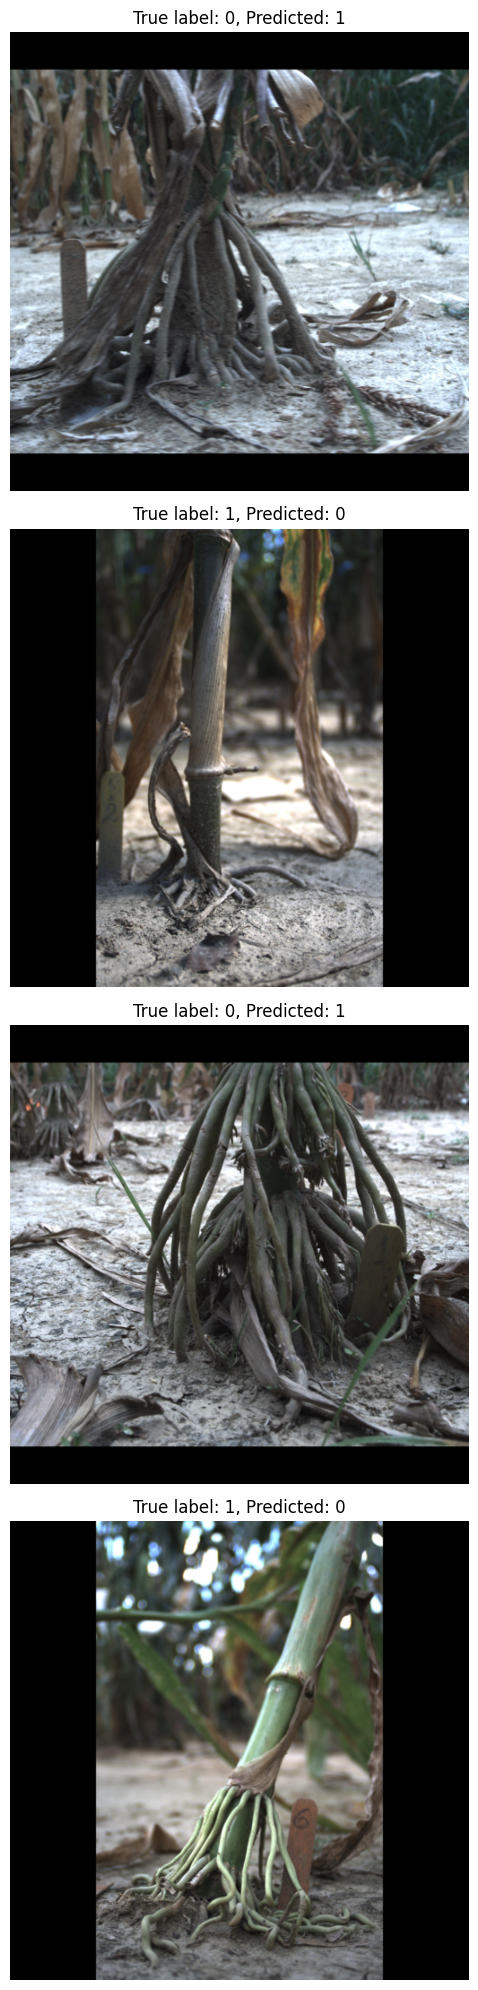

In [7]:
# Find the indices of incorrect predictions
incorrect_indices = np.where(test_y != predictions)[0]

# Plot the incorrect predictions
fig, axes = plt.subplots(len(incorrect_indices), 1, figsize=(10, len(incorrect_indices) * 5))

for idx, incorrect_idx in enumerate(incorrect_indices):
    image, label = classifier_dataset_test[incorrect_idx]
    axes[idx].imshow(image.permute(1, 2, 0))
    axes[idx].set_title(f"True label: {test_y[incorrect_idx]}, Predicted: {predictions[incorrect_idx]}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

Things to try:       
- [] CLIP Embeddings     
- [x] Different Feature extraction (average pooling)      
- [x] Increase bad samples to balance dataset      
- [] Use augmentations      


This code was pulled from the github page for CLIP:

```python 
# # Calculate the image features

# Load the model
# model, preprocess = clip.load('ViT-B/32', device)

# Load the dataset

# def get_clip_features(dataset):
#     all_features = []
#     all_labels = []
    
#     with torch.no_grad():
#         for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
#             features = model.encode_image(images.to(device))

#             all_features.append(features)
#             all_labels.append(labels)

#     return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

# def get_UNET_features(dataset):
#     all_features = []
#     all_labels = []
    
#     with torch.no_grad():
#         for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
#             features = model.encode_image(images.to(device))

#             all_features.append(features)
#             all_labels.append(labels)

#     return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

# # Calculate the image features
# train_features, train_labels = get_features(train)
# test_features, test_labels = get_features(test)

# # Perform logistic regression
# classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
# classifier.fit(train_features, train_labels)

# # Evaluate using the logistic regression classifier
# predictions = classifier.predict(test_features)
# accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
# print(f"Accuracy = {accuracy:.3f}")

```